In [1]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
from PIL import Image
from timeit import default_timer as timer
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import plot_model

import scipy.ndimage as ndi
import keras
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import plot_model
import keras.backend as tfback
from keras.regularizers import l1, l2
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

#Kaggle notebook input directory
input_path = '/kaggle/input/intel-image-classification/'
dst_path = '../working/'

### Visualization

#### Plot some images of each class in train segment folder

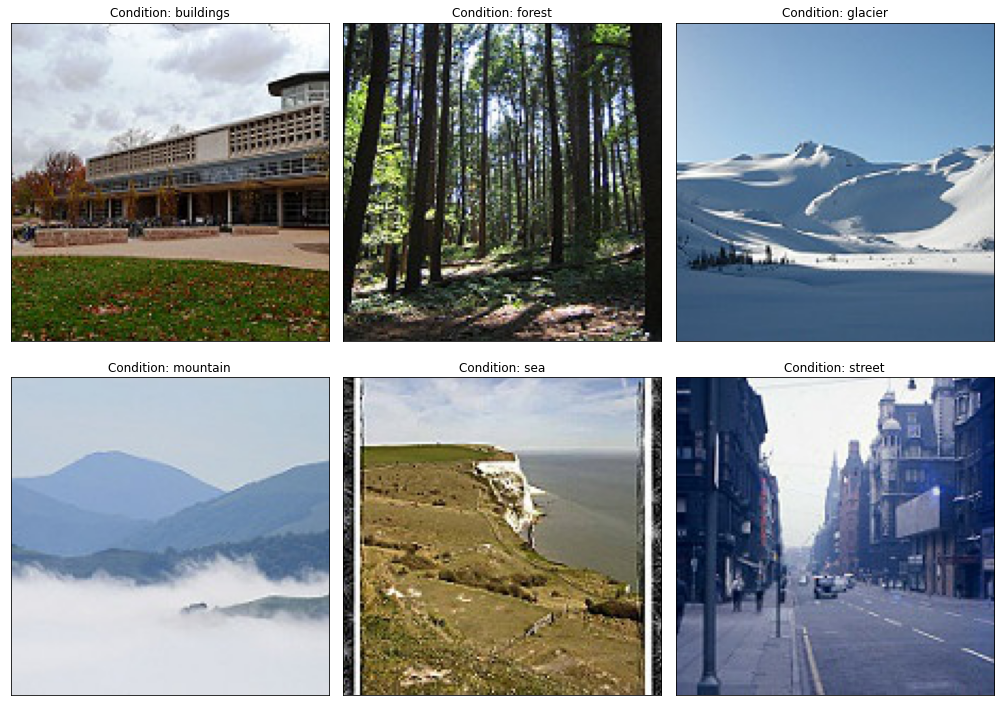

In [2]:
fig, ax = plt.subplots(2, 3, figsize=(14, 10))
ax=ax.ravel()
plt.setp(ax, xticks=[], yticks=[])
plt.subplots_adjust(hspace=0.1)
plt.tight_layout()
# grid = plt.GridSpec(2, 3, wspace = .2, hspace = .5)

train_folder=os.path.join(input_path, 'seg_train/', 'seg_train/')

for i,_dir in enumerate(['buildings/', 'forest/', 'glacier/', 'mountain/', 'sea/', 'street/']):
    im_file = os.listdir(train_folder+_dir)[0]
    full_path = train_folder+_dir+im_file
    ax[i].imshow(plt.imread(full_path), cmap='gray')
    ax[i].set_title('Condition: {}'.format(_dir[:-1]))

plt.savefig('sample_example.jpg')
plt.show()

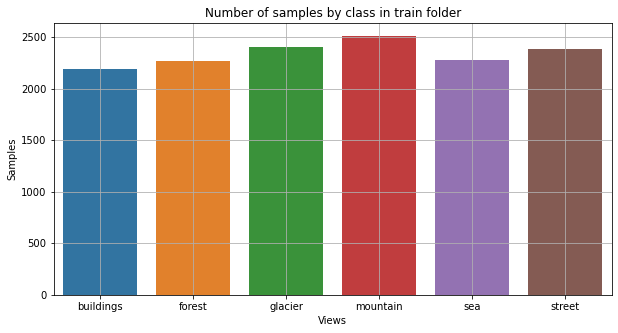

In [3]:
train_folder=os.path.join(input_path, 'seg_train/', 'seg_train/')
n_sizes={}

for i,_dir in enumerate(['buildings/', 'forest/', 'glacier/', 'mountain/', 'sea/', 'street/']):
    size=len(os.listdir(train_folder+_dir))
    n_sizes[_dir[:-1]]=size
    
plt.figure(figsize=(10,5))
sns.barplot(list(n_sizes.keys()), list(n_sizes.values()))

plt.xlabel('Views')
plt.ylabel('Samples')
plt.title('Number of samples by class in train folder')
plt.grid()
plt.savefig('samples_dist.jpg')
plt.show()

In [4]:
for row in n_sizes.items():
    print("View: " + row[0] + " , number of samples: " + str(row[1]))

View: buildings , number of samples: 2191
View: forest , number of samples: 2271
View: glacier , number of samples: 2404
View: mountain , number of samples: 2512
View: sea , number of samples: 2274
View: street , number of samples: 2382


> The histograma of intensity pixels and the cumulative distribution function help us to understand how the intensity pixels are spread in the image.

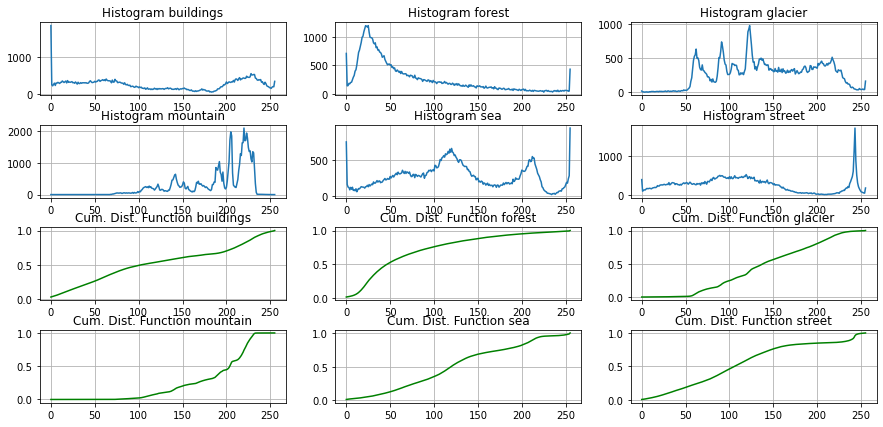

In [5]:
# Data visualization for pixel distribution 

fig, ax = plt.subplots(4, 3, figsize=(15, 7))
ax=ax.ravel()
plt.subplots_adjust(hspace=0.4, )

for i,_dir in enumerate(['buildings/', 'forest/', 'glacier/', 'mountain/', 'sea/', 'street/']):
    im_file = os.listdir(train_folder+_dir)[0]
    full_path = train_folder+_dir+im_file
    im=imageio.imread(full_path)
    hist=ndi.histogram(im, min=0, max=255, bins=256)
    cdf = hist.cumsum() / hist.sum()
    ax[i].plot(hist)
    ax[i].set_title('Histogram {}'.format(_dir[:-1]))
    ax[i].grid()
    ax[i+6].plot(cdf, 'g')
    ax[i+6].set_title('Cum. Dist. Function {}'.format(_dir[:-1]))
    ax[i+6].grid()
    

plt.savefig('pixel_dist.jpg')
plt.show()

#### Images are matrix (n1xn2) where n means the resolution of it. We can open it as numpy array and then check the resolution we are working

In [6]:
for img in os.listdir(train_folder + 'forest/')[:10]:
    final_path=os.path.join(train_folder, 'forest/', img)
    img_sample = Image.open(final_path)
    display(img_sample.size)

(150, 150)

(150, 150)

(150, 150)

(150, 150)

(150, 150)

(150, 150)

(150, 150)

(150, 150)

(150, 150)

(150, 150)

## Pre Processing

#### Move folder from input directory to working dir. The data was already splitted on test, train and pred samples.

In [7]:
def move_folder(input_folder, group_data):
    counter=0
    final_dst=os.path.join(dst_path, group_data)
    if not os.path.exists(final_dst):
        os.makedirs(final_dst)
    for group in os.listdir(input_folder):
        group_path = os.path.join(input_folder, group)
        group_dst = os.path.join(final_dst, group)
        if not os.path.exists(group_dst):
            os.makedirs(group_dst)
        for img in os.listdir(group_path):
            counter+=1
            shutil.copy2(group_path+'/'+img, group_dst+'/'+img)
    print(str(counter) + "files were replaced")

In [8]:
move_folder(train_folder, 'train')

14034files were replaced


In [9]:
test_folder=os.path.join(input_path, 'seg_test/', 'seg_test/')
move_folder(test_folder, 'test')

3000files were replaced


In [10]:
### Pipeline Pre processing and training

In [11]:
# Defining some constant variables to use in the preprocessor

train_path  = '../working/train'
test_path =  '../working/test'
IMAGE_SIZE    = (128, 128)  ##(heigth, width, rgb channels)
BATCH_SIZE    = 64
NUM_EPOCHS    = 100

### Pre processing pipeline.
    Important operations:
        - Horizontal and vertical rotation
        - Featurewise center
        - Samplewise_center
        - zca_whitening

In [12]:
def get_pipeline_prepro(train_path, test_path, img_size, batch_size):

    #Train datagen here is a preprocessor
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip = True ,
                                       vertical_flip = True ,
                                       validation_split = 0.25,
                                       featurewise_center=True,
                                       rotation_range=20,
                                       samplewise_center=True,
                                       zca_whitening=True
                                      )
    
    train_batches = train_datagen.flow_from_directory(train_path,
                                                      target_size=img_size,
                                                      shuffle=True,
                                                      subset = "training",
                                                      batch_size=batch_size,
                                                      color_mode="rgb",
                                                      class_mode="categorical"
                                                      )

    valid_batches = train_datagen.flow_from_directory(test_path,
                                                      target_size=img_size,
                                                      shuffle=True,
                                                      subset = "validation",
                                                      batch_size=batch_size,
                                                      color_mode="rgb",
                                                      class_mode="categorical"
                                                      )
    
    return train_batches, valid_batches

#### Loss Function and how it decays
    The model will save the best weigths in training process
    If ten epochs in sequence don't improve accuracy the model stops train -> means overfitting

In [13]:
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)
        
cb = TimingCallback()

In [14]:
def get_cnn_model(train_batches, valid_batches, callbacks, num_epochs, optimizer):
    # define model
    model = Sequential()

    #Convolve block
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    
    # compile model    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    # fit model
    STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
    STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size
    result=model.fit_generator(train_batches,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        callbacks = callbacks,
                        epochs = num_epochs                     
                       )
    
    return model, result

In [15]:
def plot_accs(result, epochs, img_name):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.savefig(img_name)
    plt.show()

### Adam optimizer

In [16]:
opt=tf.keras.optimizers.Adam(
    learning_rate=0.001,
)
checkpoint = ModelCheckpoint(filepath='IIC_BS64.hdf5', save_best_only=True, save_weights_only=True)
early_stop = EarlyStopping(patience=20, monitor='val_accuracy')

callbacks=[checkpoint, early_stop, cb]

train_batches, valid_batches = get_pipeline_prepro(train_path, test_path, IMAGE_SIZE, BATCH_SIZE)

Found 10528 images belonging to 6 classes.
Found 748 images belonging to 6 classes.


In [17]:
model_adam, results_adam=get_cnn_model(train_batches, valid_batches, callbacks, NUM_EPOCHS, opt)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
164/164 [==============================] - 55s 337ms/step - loss: 1.8024 - accuracy: 0.1768 - val_loss: 1.7898 - val_accuracy: 0.1747
Epoch 2/100
164/164 [==============================] - 54s 331ms/step - loss: 1.7911 - accuracy: 0.1794 - val_loss: 1.7901 - val_accuracy: 0.1761
Epoch 3/100
164/164 [==============================] - 54s 328ms/step - loss: 1.7911 - accuracy: 0.1788 - val_loss: 1.7904 - val_accuracy: 0.1761
Epoch 4/100
164/164 [==============================] - 55s 334ms/step - loss: 1.7910 - accuracy: 0.1790 - val_loss: 1.7903 - val_accuracy: 0.1719
Epoch 5/100
164/164 [==============================] - 55s 333ms/step - loss: 1.7909 - accuracy: 0.1792 - val_loss: 1.7906 - val_accuracy: 0.1705
Epoch 6/100
164/164 [==============================] - 54s 328ms/step - loss: 1.7909 - accuracy: 0.1793 - val_loss: 1.7901 - val_accuracy: 0.1790
Epoch 7/100
164/164 [==============================] - 55s 334ms/step - loss: 1.7909 - accuracy: 0.1790 - val_loss: 1.7897 -

ValueError: x and y must have same first dimension, but have shapes (64,) and (37,)

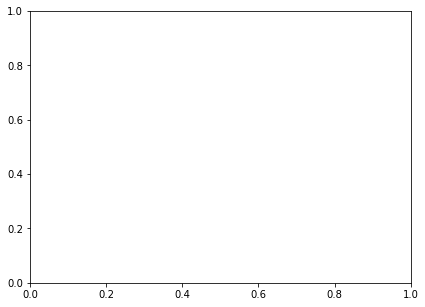

In [18]:
plot_accs(results_adam, 65, 'adam_01.jpg')

In [19]:
cb_1_total=np.sum(cb.logs)
cb_1_total

2106.50264677

In [20]:
cb_1_mean=np.mean(cb.logs)
cb_1_mean

55.43428017815789

In [21]:
np.max(results_adam.history['val_accuracy'])

0.18607954680919647

In [22]:
STEP_SIZE_TEST=valid_batches.n//valid_batches.batch_size

In [23]:
validations=[]
for i in range(10):
    valid=model_adam.evaluate_generator(generator=valid_batches, steps=STEP_SIZE_TEST)
    validations.append(valid[1])

final_eval=np.sum(validations)/10
print("A acurácia foi de: " + str(final_eval))

A acurácia foi de: 0.17627840787172316


In [24]:
model_adam.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 64)        3

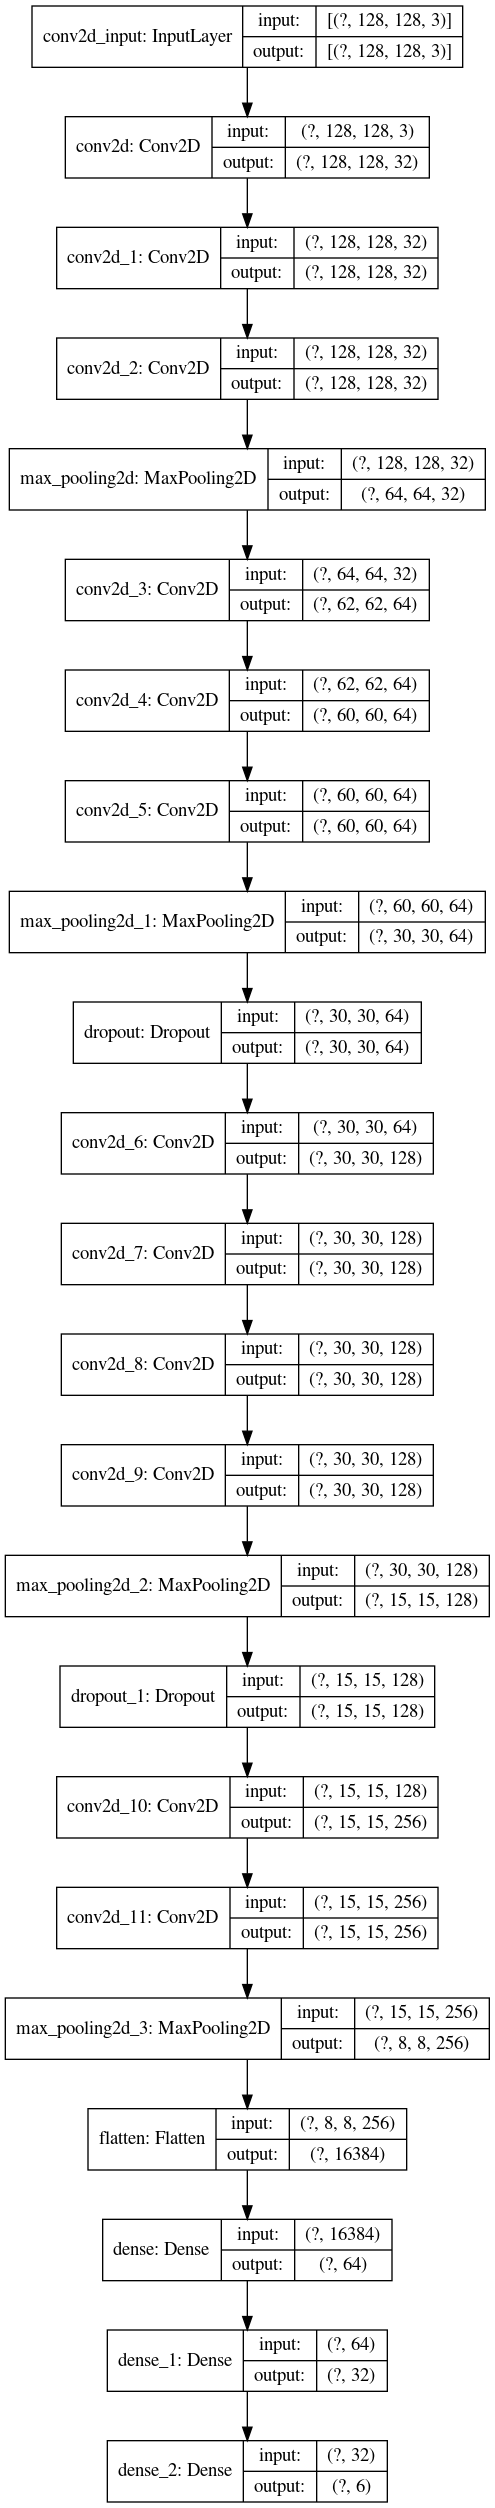

In [25]:
plot_model(model_adam, show_shapes=True, show_layer_names=True)